# Modeling - XGBoost

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score,confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc,RocCurveDisplay, accuracy_score,recall_score, roc_auc_score, PrecisionRecallDisplay
from imblearn.over_sampling import SMOTE

## Hyperparameter Tuning

In [8]:
def get_model_results(p):
    metrics = {}
    X_train = pd.read_pickle(f"../data/model_input/X_train_{p}.pkl").drop(['Polo'], axis=1)
    y_train = pd.read_pickle(f"../data/model_input/y_train_{p}.pkl")
    X_test = pd.read_pickle(f"../data/model_input/X_test_{p}.pkl").drop(['Polo'], axis=1)
    y_test = pd.read_pickle(f"../data/model_input/y_test_{p}.pkl")
    clf = XGBClassifier(colsample_bytree=0.8, gamma=1, max_depth=7, min_child_weight=1)
    clf.fit(X_train, y_train)
    metrics[f'acc_{p}'] = clf.score(X_test, y_test)
    y_pred = clf.predict(X_test)
    metrics[f'recall_{p}'] = recall_score(y_test, y_pred)
    metrics[f'auc_{p}'] = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    return metrics, clf, X_test, y_test
    

In [9]:
polos = ['Porto Alegre', 'Marabá', 'Brasília', 'Belo Horizonte', 'Juazeiro do Norte', 'Recife']
metrics = []
models = []
test = []
for p in polos:
    mt, md, X_test, y_test = get_model_results(p)
    metrics.append(mt)
    models.append(md)
    test.append([X_test, y_test])

In [10]:
metrics

[{'acc_Porto Alegre': 0.9269355502675783,
  'recall_Porto Alegre': 0.18874149888896372,
  'auc_Porto Alegre': 0.816730813627533},
 {'acc_Marabá': 0.7208864670524128,
  'recall_Marabá': 0.06712582236842106,
  'auc_Marabá': 0.5655292396407132},
 {'acc_Brasília': 0.8786588730839837,
  'recall_Brasília': 0.11979732175171914,
  'auc_Brasília': 0.7419034129986523},
 {'acc_Belo Horizonte': 0.7858060640445875,
  'recall_Belo Horizonte': 0.16821658917054147,
  'auc_Belo Horizonte': 0.7057730440551424},
 {'acc_Juazeiro do Norte': 0.7734749916596094,
  'recall_Juazeiro do Norte': 0.05912040374909877,
  'auc_Juazeiro do Norte': 0.5394295654718906},
 {'acc_Recife': 0.775328745001538,
  'recall_Recife': 0.44108924238339176,
  'auc_Recife': 0.7877742500832107}]

## PR Curve Analyss

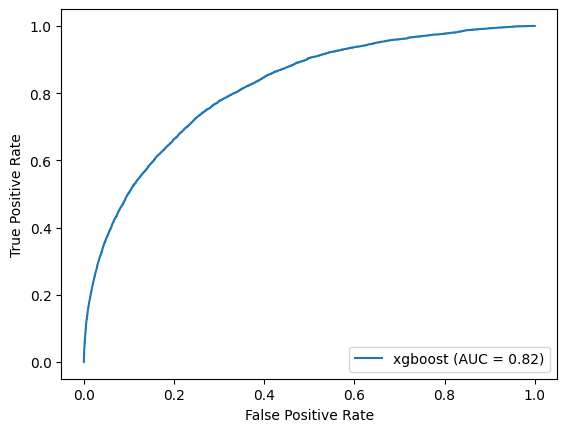

In [16]:
######### PORTO ALEGRE

fpr, tpr, thresholds = roc_curve(test[0][1], models[0].predict_proba(test[0][0])[::,1])
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='xgboost').plot()
plt.show()

## Evaluation

In [4]:
clf.score(X_test, y_test)

0.9173023559497252

In [30]:
recall_score(y_test, y_pred)

0.6280988951765023

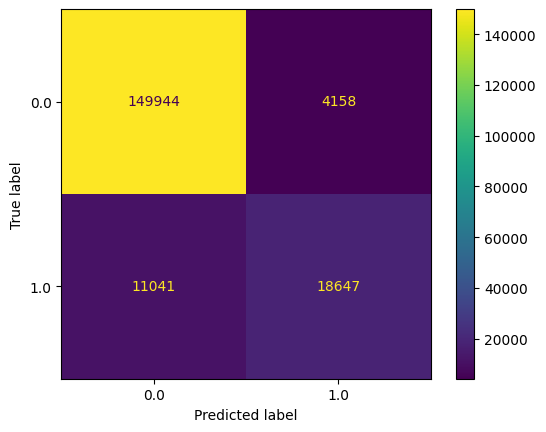

In [6]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_).plot()
plt.show()

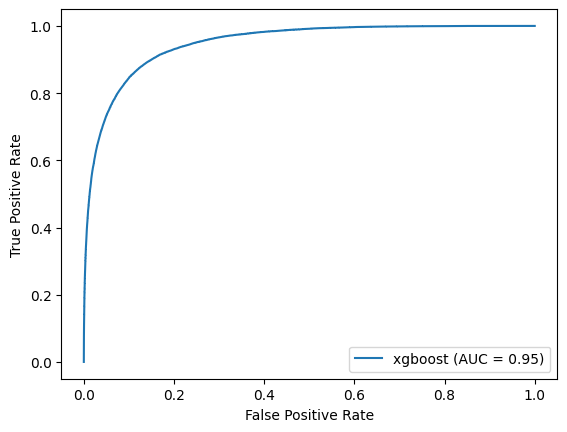

In [7]:
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='xgboost').plot()
plt.show()

## Changing threshold

In [8]:
y_prob =  clf.predict_proba(X_test)[:,1]


In [36]:
### Bayesian risk
c01 = 1200
c10 = 100
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
nu = c10*(1-np.mean(y_test))/(c01*np.mean(y_test))
t = nu/(1+nu)
y_pred_bayes = (y_prob>t)*1

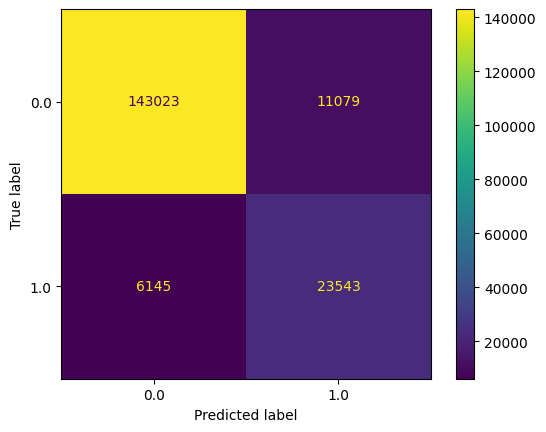

In [37]:
cm = confusion_matrix(y_test, y_pred_bayes, labels=clf.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_).plot()
plt.show()

In [38]:
accuracy_score(y_test, y_pred_bayes)

0.9062843462647587

In [39]:
recall_score(y_test, y_pred_bayes)

0.7930140123955807

## Save Model

In [41]:
pickle.dump(clf, open("data/models/xgb.sav", 'wb'))